# **Configuração Geral**

## Imports

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fractions import Fraction
import joblib
import scipy.stats as stats
from sklearn.metrics import r2_score
from joblib import dump

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity

## Funções

In [85]:
# Converte uma string que representa polegadas para um float
def polegadas(value):

    # Divide a string recebida
    value = value.strip()

    # Se a string tem mais de uma parte, obtém a parte inteira e calcula a parte decimal
    if ' ' in value:
        inteiro, decimal = value.split(' ') # a parte inteira é o que está antes do ' ', a parte decimal é o que está depois
        polegadas = float(inteiro) + float(Fraction(decimal))

    else:
        polegadas = float(value)
    
    return polegadas

# -------------------------------
# Testa, otimiza e retorna o modelo de melhor performance
def seleciona_modelos(df, model_param_grid):
    # Preparar os dados
    df1 = df.copy()
    df_train = df1[df1['tipo_poco'] != 'DIRECIONAL']
    
    X_train = df_train[['fase', 'lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas']]
    y_train = df_train['tipo_poco']
    
    # Codificar target
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    best_model = None
    best_score = 0
    best_metrics = None
    
    # Iterar sobre os modelos e grids de parâmetros fornecidos
    for model_name, (model, param_grid) in model_param_grid.items():
        print(f"\nTestando {model_name}...")
        
        # Inicializar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train_encoded)
        
        # Obter o melhor modelo
        current_best_model = grid_search.best_estimator_
        current_best_score = grid_search.best_score_
        
        # Avaliar o modelo no conjunto de treinamento completo
        y_train_pred_encoded = current_best_model.predict(X_train)
        
        # Imprimir relatórios de avaliação
        # print(f"Modelo: {model_name}")
        # print("Melhores Parâmetros Encontrados:")
        # print(grid_search.best_params_)
        
        # print("Relatório de Classificação (Treinamento):")
        report = classification_report(y_train_encoded, y_train_pred_encoded, target_names=label_encoder.classes_)
        # print(report)
        
        # print("Acurácia no Conjunto de Treinamento:")
        accuracy = accuracy_score(y_train_encoded, y_train_pred_encoded)
        # print(f"{accuracy:.4f}")
        
        # Verificar se é o melhor modelo até agora
        if current_best_score > best_score:
            best_score = current_best_score
            best_model = current_best_model
            best_metrics = {
                'model_name': model_name,
                'best_params': grid_search.best_params_,
                'classification_report': report,
                'accuracy': accuracy
            }
    
    # Imprimir as métricas do melhor modelo dentre todos os testados
    print("\nMelhor Modelo:")
    print(f"Modelo: {best_metrics['model_name']}")
    print("Melhores Parâmetros Encontrados:")
    print(best_metrics['best_params'])
    
    print("Relatório de Classificação (Treinamento):")
    print(best_metrics['classification_report'])
    
    print("Acurácia no Conjunto de Treinamento:")
    print(f"{best_metrics['accuracy']:.4f}")
    
    return best_model
# -------------------------------

# Função para salvar a grid de gráficos
def save_grid_plot(filename):
    plt.savefig(f'img/{filename}')
    # plt.close()
# -------------------------------

# Função para gerar e salvar gráficos de distribuição em uma grid
def plot_distributions_grid(df, columns):
    num_vars = len(columns)
    fig, axes = plt.subplots(nrows=(num_vars + 2) // 3, ncols=3, figsize=(18, 4 * ((num_vars + 2) // 3)))
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        sns.histplot(df[column], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribuição de {column}')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')  # Desliga os eixos restantes
    
    plt.tight_layout()
    save_grid_plot('distributions_grid.png')
    plt.show() # precisa vir por último, senão nenhum gráfico é exibido no notebook
# -------------------------------

# Função para gerar gráficos boxplots para ajudar a identificar outliers
def detect_outliers(df, numeric_columns):
    """
    Detecta outliers nas variáveis numéricas e salva gráficos boxplot em uma grid.
    
    Parameters:
    df (pd.DataFrame): DataFrame contendo os dados.
    numeric_columns (list): Lista de nomes das colunas numéricas para análise.
    """
    # Criar uma grid de gráficos
    n = len(numeric_columns)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 5))

    for ax, col in zip(axes, numeric_columns):
        sns.boxplot(x=df[col], ax=ax)
        ax.set_title(f'Boxplot de {col}')

    # Ajustar layout e salvar a imagem
    plt.tight_layout()
    save_grid_plot('outliers_boxplots.png')
    plt.show()
# -------------------------------

# Função para contar frequências e visualizar distribuição de valores
def dist_non_numeric(df, non_numeric_features):
    for feature in non_numeric_features:
        # Contar frequências
        freq_counts = df[feature].value_counts()
        print(f"\nContagem de Frequências para {feature}:")
        print(freq_counts)
        
        # Visualizar distribuição de valores
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=feature)
        plt.title(f'Distribuição de {feature}')
        save_grid_plot(f'{feature}_distribution.png')
        plt.show()
# -------------------------------

# Função para plotar o gráfico da análise bivariada por tipo_poco
def bivariada_tipo_poco(df):
    # Criar a grid de gráficos
    fig, axes = plt.subplots(2, 2, figsize=(13, 8))

    # Gráfico boxplot para 'lda_lamina_d_agua' por 'tipo_poco'
    sns.boxplot(x='tipo_poco', y='lda_lamina_d_agua', data=df, ax=axes[0, 0])
    axes[0, 0].set_title('LDA Lamina d\'Agua por Tipo de Poço')

    # Gráfico boxplot para 'metragem' por 'tipo_poco'
    sns.boxplot(x='tipo_poco', y='metragem', data=df, ax=axes[0, 1])
    axes[0, 1].set_title('Metragem por Tipo de Poço')

    # Histograma para contar fases por tipo_poco
    for tipo, ax in zip(['HORIZONTAL', 'VERTICAL'], [axes[1, 0], axes[1, 1]]):
        subset = df[df['tipo_poco'] == tipo]
        sns.histplot(subset, x='fase', bins=4, ax=ax, kde=False)
        ax.set_title(f'Contagem de Fases - {tipo}')

    # Ajustar layout
    plt.tight_layout()

    # Salvar imagem
    save_grid_plot('bivariada_tipo_poco.png')

    #Exibe a imagem
    plt.show()
# -------------------------------

# Função que gera gráficos para análise bivariada por 'fase'
def bivariada_fases(df):
    # Criar a grid de gráficos
    fig, axes = plt.subplots(2, 2, figsize=(13, 8))

    # Gráfico boxplot para 'lda_lamina_d_agua' por 'fase'
    sns.boxplot(x='fase', y='lda_lamina_d_agua', data=df, ax=axes[0, 0])
    axes[0, 0].set_title('LDA Lamina d\'Agua por Fase')

    # Gráfico boxplot para 'metragem' por 'fase'
    sns.boxplot(x='fase', y='metragem', data=df, ax=axes[0, 1])
    axes[0, 1].set_title('Metragem por Fase')

    # Gráfico boxplot para 'diametro_fase_polegadas' por 'fase'
    sns.boxplot(x='fase', y='diametro_fase_polegadas', data=df, ax=axes[1, 0])
    axes[1, 0].set_title('Diâmetro por Fase')

    # Histograma para contagem de fases
    sns.histplot(df, x='fase', bins=4, ax=axes[1, 1], kde=False)
    axes[1, 1].set_title('Contagem de Poços por Fase')

    # Ajustar layout
    plt.tight_layout()

    # Salvar imagem
    save_grid_plot('bivariada_fases.png')

    # Mostrar imagem
    plt.show()
# -------------------------------

# Função para calcular e exibir R2
def plot_with_regression(x, y, data, ax, title):
    sns.regplot(x=x, y=y, data=data, ax=ax)
    ax.set_title(title)
    r2 = r2_score(data[x], data[y])
    ax.annotate(f'R² = {r2:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='red')
# -------------------------------

# Calcula um score de similaridade comparando as features do dataset com o poço informado
# Poços idênticos ao informado --> score = 1
def calcular_score_similaridade(poco_informado, dataset):

    # Copia o df original para preservá-lo
    dataset = dataset.copy()

    # Inicializar uma lista para armazenar os scores de similaridade
    scores = []

    # Obter os valores do poço informado
    tipo_poco_informado = poco_informado['tipo_poco'].values[0]
    nfases_informado = poco_informado['nfases'].values[0]
    metragem_total_informado = poco_informado['metragem_total'].values[0]
    lda_informado = poco_informado['lda_lamina_d_agua'].values[0]

    # Iterar sobre cada poço no dataset
    for index, poco in dataset.iterrows():
        score = 0

        # 1. Verificar se o tipo de poço é o mesmo
        if poco['tipo_poco'] == tipo_poco_informado:
            score += 1

        # 2. Calcular a similaridade de nfases
        nfases_diferenca = abs(poco['nfases'] - nfases_informado)
        nfases_max = max(poco['nfases'], nfases_informado)
        score += 1 - (nfases_diferenca / nfases_max) if nfases_max > 0 else 0

        # 3. Calcular a similaridade de metragem_total
        metragem_total_diferenca = abs(poco['metragem_total'] - metragem_total_informado)
        metragem_total_max = max(poco['metragem_total'], metragem_total_informado)
        score += 1 - (metragem_total_diferenca / metragem_total_max) if metragem_total_max > 0 else 0

        # 4. Calcular a similaridade de lâmina d'água
        lda_diferenca = abs(poco['lda_lamina_d_agua'] - lda_informado)
        lda_max = max(poco['lda_lamina_d_agua'], lda_informado)
        score += 1 - (lda_diferenca / lda_max) if lda_max > 0 else 0

        # Iterar sobre as fases do poço informado
        for fase in poco_informado['fase'].unique():
            fase = str(fase)  # Certificar que estamos lidando com strings
            if fase in poco.index and fase in poco_informado.columns:
                # 1. Calcular a similaridade de diâmetro da fase
                diametro_diferenca = abs(poco[f'diametro_{fase}'] - poco_informado[f'diametro_{fase}'].values[0])
                diametro_max = max(poco[f'diametro_{fase}'], poco_informado[f'diametro_{fase}'].values[0])
                score += 1 - (diametro_diferenca / diametro_max) if diametro_max > 0 else 0

                # 2. Calcular a similaridade de metragem da fase
                metragem_diferenca = abs(poco[f'metragem_{fase}'] - poco_informado[f'metragem_{fase}'].values[0])
                metragem_max = max(poco[f'metragem_{fase}'], poco_informado[f'metragem_{fase}'].values[0])
                score += 1 - (metragem_diferenca / metragem_max) if metragem_max > 0 else 0

        # Armazenar o score calculado
        scores.append(score)

    # Normalizar o score final do poço analisado para ficar entre 0 e 1
    max_score = max(scores) if scores else 1
    dataset['score_similaridade'] = [score / max_score for score in scores]

    # Agrupar o dataset por nome_do_poco e calcular a média do score de similaridade
    dataset_agg = dataset.groupby('nome_do_poco')['score_similaridade'].mean().reset_index()

    # Ordenar o dataset agregado em ordem decrescente de acordo com o score de similaridade
    dataset_agg = dataset_agg.sort_values(by='score_similaridade', ascending=False)

    # Adicionar a coluna de ranking de similaridade
    dataset_agg['ranking_similaridade'] = dataset_agg['score_similaridade'].rank(method="dense", ascending=False).astype(int)

    return dataset_agg
# -------------------------------

# Função que calcula a Precision at K, métrica para comparar os modelos
def precision_at_k(result_sorted, k=4):
    """
    Calcula a Precisão em k (Precision at k).

    Parâmetros:
    - result_sorted (DataFrame): DataFrame ordenado com as colunas 'ranking_similaridade' e 'similaridade_knn' 
    (ou outro score de similaridade gerado por outros algos).
    - k (int): Número de itens a considerar no topo (no nosso caso são 4).

    Retorna:
    - float: Precisão em k.
    - Ex: precisão de 25% significa que apenas 01 item com ranking relevante apareceu no top_4 do modelo
    """
    # Obtendo os top-k poços pelo ranking do modelo
    top_k_model = result_sorted.head(k)

    # Verificando se 'ranking_similaridade' de 1 a 4 estão nos top-k
    rankings_relevantes = set(range(1, 5))
    top_k_rankings = set(top_k_model['ranking_similaridade'])

    # Calculando a interseção = quantos dos itens com ranking relevante estão no top_k do modelo
    relevantes_no_top_k = len(rankings_relevantes.intersection(top_k_rankings))

    # Calculando a Precisão em k
    precisao_em_k = relevantes_no_top_k / k

    return precisao_em_k
# -------------------------------

# Calcula a similaridade cosseno entre os poços
def calcular_similaridade_cosseno(df, df_poco_informado, features, df_ordenado):
    """
    Calcula a similaridade do cosseno entre o poço informado e o dataset e retorna o dataset ordenado.
    
    Parâmetros:
    - df (DataFrame): DataFrame com todos os poços.
    - df_poco_informado (DataFrame): DataFrame com o poço informado.
    - features (list): Lista das características a serem usadas para calcular a similaridade.

    Retorna:
    - DataFrame: Dataset ordenado pela similaridade do cosseno.
    """
    # Copia df_poco_informado para preservar os dados
    df_poco_informado_encoded = df_poco_informado.copy()
    # Encodar poco_informado['tipo_poco'] como binário
    df_poco_informado_encoded['tipo_poco'] = df_poco_informado_encoded['tipo_poco'].map({'HORIZONTAL': 0, 'VERTICAL': 1})
    
    # Escalar os dados
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features]) # 'df' fornecido à função já teve 'tipo_poco' encodado
    X_poco_informado = scaler.transform(df_poco_informado_encoded[features])

    # Calcular a similaridade do cosseno
    similaridade_cosseno = cosine_similarity(X_poco_informado, X)[0]

    # Adicionar a similaridade ao DataFrame
    df['similaridade_cosseno'] = similaridade_cosseno

    # Ordenar o DataFrame pela similaridade do cosseno
    df_ordenado_cosseno = df.sort_values(by='similaridade_cosseno', ascending=False).reset_index(drop=True)

    # Fazer o MERGE de df_ordenado_cosseno com df_ordenado para obter 'ranking_similaridade' e 'score_similaridade'
    df_ordenado_cosseno = df_ordenado_cosseno.merge(df_ordenado[['nome_do_poco', 'ranking_similaridade', 'score_similaridade']],
                                                    on='nome_do_poco', how='left')

    return df_ordenado_cosseno
# -------------------------------



# **Carregando Dados**

In [29]:
# Carregando dados csv
df = pd.read_csv('data/dados_pocos.csv')
df.head()

,Unnamed: 0,Nome do Poço,Fase,Tipo Poço,LDA (Lâmina D'Água),Diâmetro Fase,Metragem,NFases
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3


**Características de um poço:**

- **Nome**: Nome que identifica o projeto do poço
- **Fase**: É o número da fase. Um projeto é dividido em fases.
- **Tipo Poço**: Existem aqui 2 tipos de poços VERTICAL ou HORIZONTAL.
- **LDA (Lâmina D'Água)**: LDA é o valor em metros, que corresponde a distância entre a superfície do mar até o ponto de perfuração em poços  subaquáticos.
- **Diâmetro Fase**: Para cada fase da perfuração pode-se usar uma broca com diâmetro diferente. Aqui o diâmetro é descrito em polegadas.
- **Metragem**: Valor em metros que corresponde ao total perfurado naquela fase.
- **N_Fases**: Corresponde ao número total de fases que o projeto exigiu.

# **Limpeza dos Dados**
- Tratamento de valores ausentes
- Remoção de outliers
- Correção de tipos de dados

In [30]:
# Renomear as colunas para o padrão PEP8
df.columns = ['index', 'nome_do_poco', 'fase', 'tipo_poco', 'lda_lamina_d_agua', 'diametro_fase', 'metragem', 'nfases']

# Remover a coluna de índices 'Unnamed: 0'
df = df.drop(columns=['index'])

# Exibir df
df.head()

,nome_do_poco,fase,tipo_poco,lda_lamina_d_agua,diametro_fase,metragem,nfases
0,6C5G4M,1,VERTICAL,598.0,26,607.0,4
1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4
2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4
3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4
4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3


In [31]:
# Verificar tipos de cada coluna
print(df.dtypes)

nome_do_poco          object
fase                   int64
tipo_poco             object
lda_lamina_d_agua    float64
diametro_fase         object
metragem             float64
nfases                 int64
dtype: object


In [32]:
# Verificar quantidade de valores ausentes por coluna
missing_values = df.isna().sum()
missing_values_percentage = (missing_values / len(df)) * 100
missing_values_df = pd.DataFrame({'valores_nulos': missing_values, 'percentual': missing_values_percentage})
print(missing_values_df)

                   valores_nulos  percentual
nome_do_poco                   0         0.0
fase                           0         0.0
tipo_poco                      0         0.0
lda_lamina_d_agua              0         0.0
diametro_fase                  0         0.0
metragem                       0         0.0
nfases                         0         0.0


In [33]:
# Verificar quantidade de linhas duplicadas
duplicate_count = df.duplicated().sum()
print(f'Quantidade de linhas duplicadas: {duplicate_count}')

Quantidade de linhas duplicadas: 0


In [34]:
# Converte coluna de string para float
df['diametro_fase_polegadas'] = df['diametro_fase'].apply(polegadas)
df.drop(columns='diametro_fase', inplace=True)
df.dtypes

nome_do_poco                object
fase                         int64
tipo_poco                   object
lda_lamina_d_agua          float64
metragem                   float64
nfases                       int64
diametro_fase_polegadas    float64
dtype: object

## Corrigindo a coluna 'tipo_poco'
- O exercício informa que existem apenas 02 tipos: VERTICAL e HORIZONTAL
- Mas o dataset tem mais valores além desses: DIRECIONAL e '0'
- data imputting

In [35]:
df['tipo_poco'].unique()

array(['VERTICAL', 'DIRECIONAL', '0', 'HORIZONTAL'], dtype=object)

Diante da quantidade de valores incorretos, tenho que pensar numa abordagem cautelosa para substituir esses valores.

In [36]:
# Contando quantas linhas têm valores incorretos para 'tipo_poco'
counts = df['tipo_poco'].value_counts()
direcional_count = counts.get('DIRECIONAL', 0)
zero_count = counts.get('0', 0)

# Calcular a porcentagem
total_count = len(df['tipo_poco'])
direcional_perc = (direcional_count / total_count) * 100
zero_perc = (zero_count / total_count) * 100

print(f"Porcentagem de valores com DIRECIONAL: {direcional_perc:.2f}%")
print(f"Porcentagem de valores com 0: {zero_perc:.2f}%")

Porcentagem de valores com DIRECIONAL: 35.80%
Porcentagem de valores com 0: 1.42%


### Imputação de dados com Machine Learning
- Vou utilizar um modelo de Machine Learning para prever (**classificar**) o valor correto de 'tipo_poco' com base nas características das ocorrências corretas do dataset. 
- Esse modelo será aplicado às ocorrências com 'tipo_poco' = 'DIRECIONAL'
- **Por que escolhi essa abordagem?** Para preservar ao máximo as características do dataset após a imputação de dados. Usar um método mais simples (como a moda) sobre uma grande quantidade de ocorrências (~36%) poderia induzir os modelos de ML ao erro durante a fase de modelagem, pois ele poderia encontrar características de um poço HORIZONTAL junto com o 'tipo_poco' VERTICAL, por exemplo.

In [37]:
# Primeiro eu vou tratar as ocorrências com zero: vou remover todas as linhas com valores '0', já que são poucas (1.4%)
df = df[df['tipo_poco'] != '0']

In [44]:
# Definir os modelos e seus respectivos grids de parâmetros
model_param_grid = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }),
    'DecisionTree': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    })
}

# Testar os modelos e obter o melhor
best_model = seleciona_modelos(df, model_param_grid)


Testando RandomForest...



Testando KNN...

Testando DecisionTree...

Melhor Modelo:
Modelo: RandomForest
Melhores Parâmetros Encontrados:
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Relatório de Classificação (Treinamento):
              precision    recall  f1-score   support

  HORIZONTAL       0.96      0.81      0.88      1715
    VERTICAL       0.94      0.99      0.96      4971

    accuracy                           0.94      6686
   macro avg       0.95      0.90      0.92      6686
weighted avg       0.94      0.94      0.94      6686

Acurácia no Conjunto de Treinamento:
0.9429


In [46]:
# Gravar melhor modelo de imputação
joblib.dump(best_model, 'models/best_model.pkl')

['models/best_model.pkl']

In [58]:
# Imputar os dados corretos em 'tipo_poco' utilizando o melhor modelo de imputação

# Carregar o melhor modelo encontrado
best_model = joblib.load('models/best_model.pkl')

# Preparar os dados para previsão
df_direcional = df[df['tipo_poco'] == 'DIRECIONAL'] # monta um df apenas com as ocorrências de 'DIRECIONAL'
X_direcional = df_direcional[['fase', 'lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas']]

# Codificar o target apenas com os rótulos de 'HORIZONTAL' e 'VERTICAL'
label_encoder = LabelEncoder()
label_encoder.fit(['HORIZONTAL', 'VERTICAL'])  # Ajustar encoder com rótulos do modelo --> modelo foi treinado para retornar '0' e '1' apenas (HORIZONTAL e VERTICAL, não nessa ordem)

# Realizar previsões
y_pred_encoded = best_model.predict(X_direcional)

# Converter previsões de volta para os rótulos originais
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Substituir valores 'DIRECIONAL' com previsões
df.loc[df['tipo_poco'] == 'DIRECIONAL', 'tipo_poco'] = y_pred

In [65]:
# Gravar dataframe limpo
df.to_csv('data/df_cleaned.csv', index=False)
print('Dataframe limpo gravado com sucesso!')

Dataframe limpo gravado com sucesso!


# **Análise Exploratória de Dados (EDA)**
- Extrair insights de negócio
- Estatísticas descritivas
- Distribuições de variáveis
- Análise de correlação
- Visualizações (histogramas, scatter plots, heatmaps, etc.)

In [3]:
# Carregando dataset limpo
df = pd.read_csv('data/df_cleaned.csv')
df.head()

,nome_do_poco,fase,tipo_poco,lda_lamina_d_agua,metragem,nfases,diametro_fase_polegadas
0,6C5G4M,1,VERTICAL,598.0,607.0,4,26.00
1,6C5G4M,2,VERTICAL,598.0,1306.0,4,17.50
2,6C5G4M,3,VERTICAL,598.0,1201.0,4,12.25
3,6C5G4M,4,VERTICAL,598.0,1445.0,4,8.50
4,8030JC,1,VERTICAL,0.0,410.0,3,17.50


## Estatísticas Descritivas

In [70]:
# Informações gerais do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10498 entries, 0 to 10497
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   nome_do_poco             10498 non-null  object 
 1   fase                     10498 non-null  int64  
 2   tipo_poco                10498 non-null  object 
 3   lda_lamina_d_agua        10498 non-null  float64
 4   metragem                 10498 non-null  float64
 5   nfases                   10498 non-null  int64  
 6   diametro_fase_polegadas  10498 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 574.2+ KB


In [71]:
# Estatística descritiva (apenas das colunas numéricas)
df.describe().round(2)

,fase,lda_lamina_d_agua,metragem,nfases,diametro_fase_polegadas
count,10498.00,10498.00,10498.00,10498.00,10498.00
mean,2.67,1115.23,680.76,4.27,16.80
std,1.54,729.06,563.40,1.81,8.54
min,1.00,0.00,0.00,1.00,0.00
25%,1.00,466.75,188.25,3.00,9.50
50%,2.00,1098.00,609.00,4.00,12.25
75%,4.00,1735.00,1027.00,5.00,22.00
max,8.00,2988.00,4040.00,9.00,42.00


## Análise univariada
- Compreender distribuição
- Procurar outliers

### Análise Univariada - Dados Numéricos

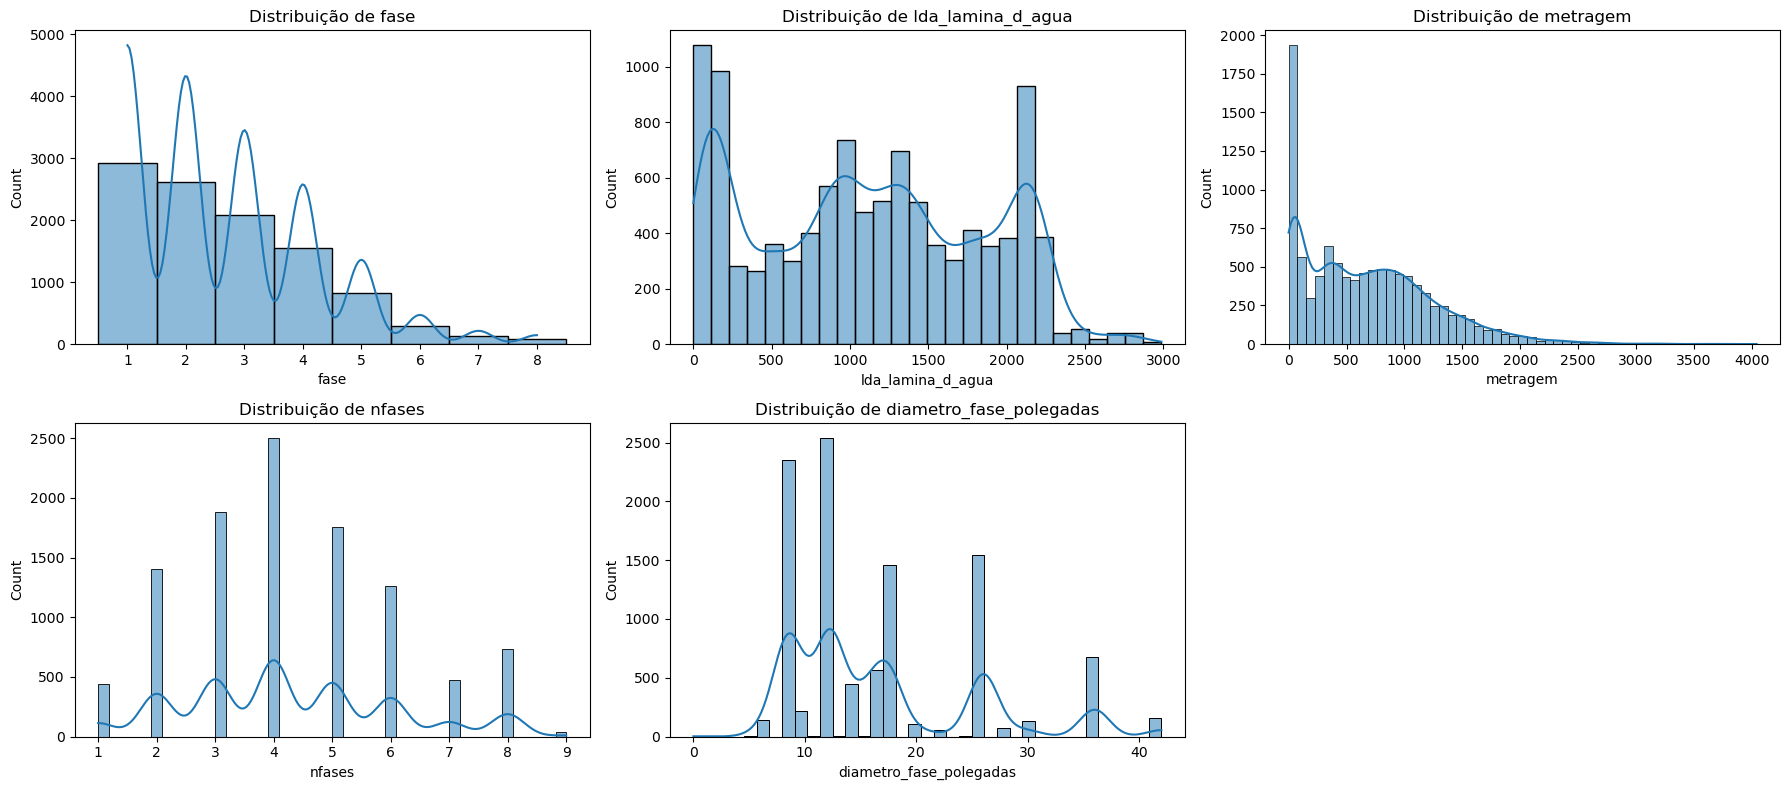

In [32]:
# Analisar a distribuição de variáveis numéricas
numeric_columns = ['fase', 'lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas']
plot_distributions_grid(df, numeric_columns)

Procurando outliers:

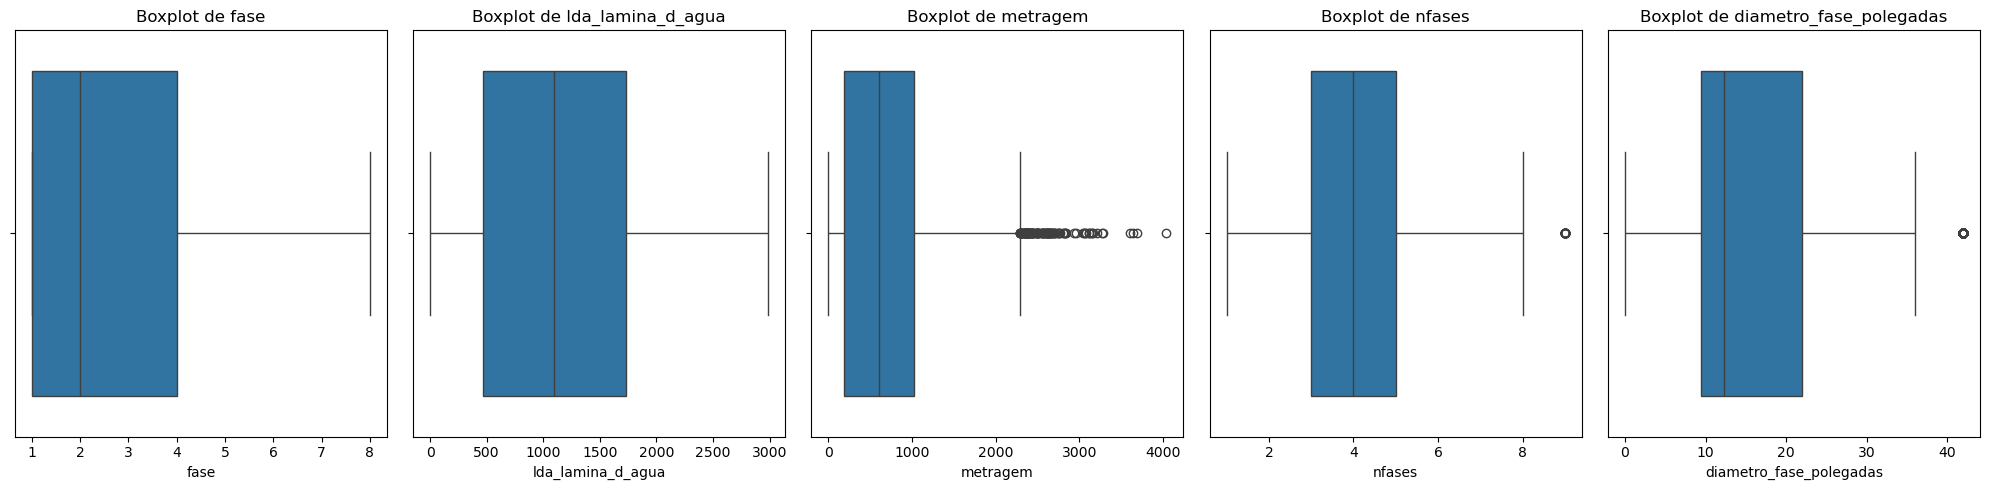

In [33]:
# Procurando outliers
detect_outliers(df, ['fase', 'lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas'])

### Análise Univariada - Dados Não-Numéricos


Contagem de Frequências para tipo_poco:
tipo_poco
HORIZONTAL    5527
VERTICAL      4971
Name: count, dtype: int64


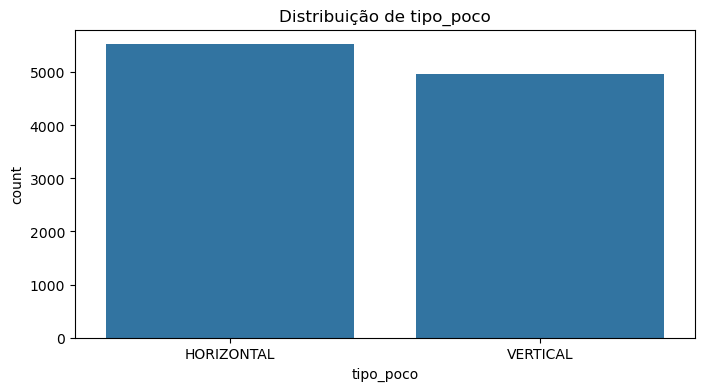

In [34]:
# Distribuição de tipos de poço
dist_non_numeric(df, ['tipo_poco'])

## Análise Bivariada
- relação entre 'tipo_poco' e features numéricas:
    - média, mediana, desvio padrão, contagem (usar 'describe')
    - gráficos
- relação entre 'fase' e features numéricas
- relação entre features numéricas
    - gráficos de dispersão com linha de regressão linear exibindo o r2
- correlação entre features
    - codificar as categorias para números
    - calcular a matriz de correlação (heatmap)

In [35]:
# 'fase' é, na verdade, uma categoria
# Converter 'fase' e 'tipo_poco' para categóricos
df['fase'] = df['fase'].astype('category')
df['tipo_poco'] = df['tipo_poco'].astype('category')

In [45]:
# Analisando apenas colunas numéricas
numeric_columns = df.select_dtypes(include='number').columns

### Relação entre 'tipo_poco' e as features numéricas

In [37]:
import pandas as pd

# Agrupar por 'tipo_poco' e descrever as variáveis numéricas
grouped_df = df.groupby('tipo_poco').describe(include='number').round(2)

# Transpor o DataFrame para que as colunas representem os tipos de 'tipo_poco'
transposed_df = grouped_df.T

transposed_df

/tmp/ipykernel_845/2218035633.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('tipo_poco').describe(include='number').round(2)


tipo_poco                      HORIZONTAL  VERTICAL
lda_lamina_d_agua       count     5527.00   4971.00
                        mean      1020.27   1220.82
                        std        652.93    792.11
                        min          0.00      0.00
                        25%        457.00    474.00
                        50%        988.00   1275.00
                        75%       1467.00   1967.00
                        max       2673.00   2988.00
metragem                count     5527.00   4971.00
                        mean       698.03    661.56
                        std        534.48    593.38
                        min          0.00      0.00
                        25%        266.50     86.00
                        50%        653.00    550.00
                        75%       1035.00   1019.00
                        max       4040.00   3683.00
nfases                  count     5527.00   4971.00
                        mean         3.74      4.86
                        std          1.65      1.80
                        min          1.00      1.00
                        25%          2.00      4.00
                        50%          4.00      5.00
                        75%          5.00      6.00
                        max          9.00      9.00
diametro_fase_polegadas count     5527.00   4971.00
                        mean        16.15     17.53
                        std          8.10      8.96
                        min          0.00      0.00
                        25%          9.50     12.25
                        50%         12.25     14.75
                        75%         17.50     26.00
                        max         42.00     42.00

- Distribuição de valores de metragem, lâmina dágua por tipo de poço;
- Contagem de fases por tipo de poço.

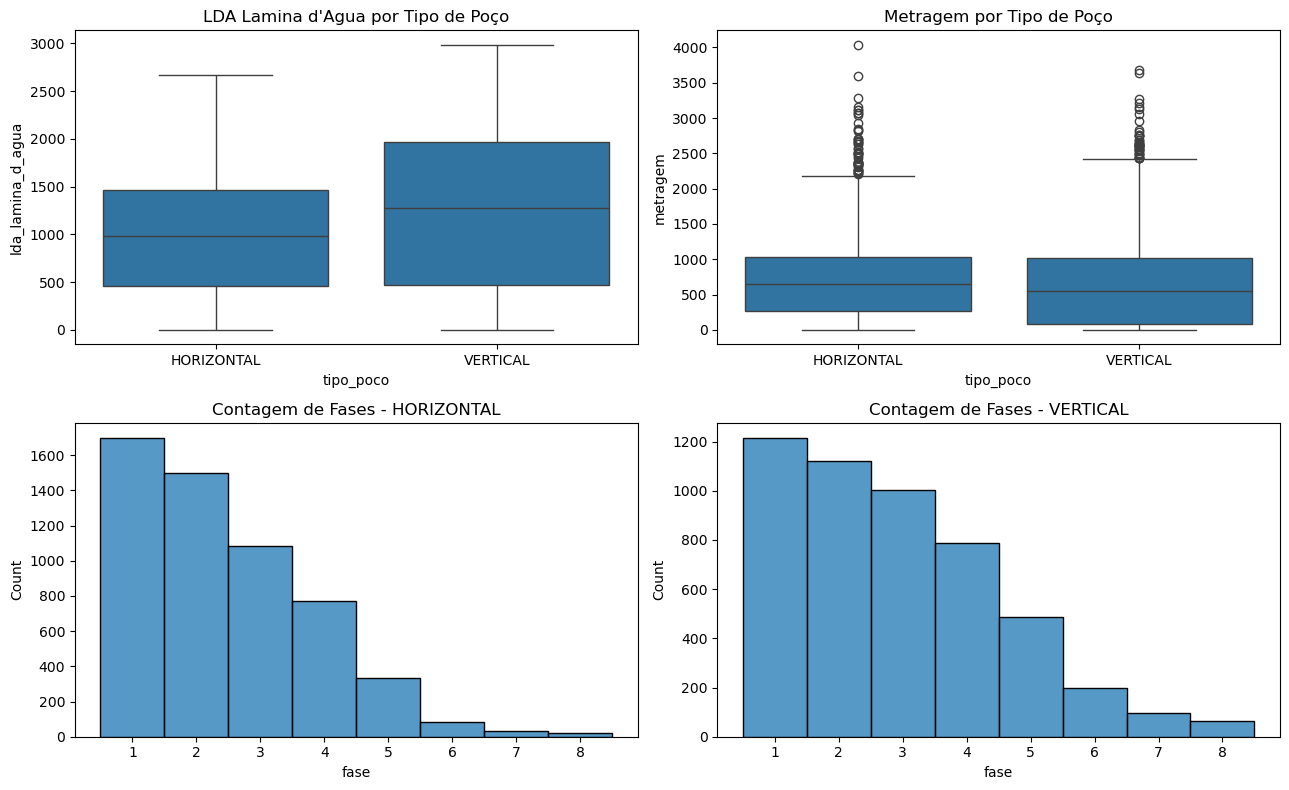

In [44]:
bivariada_tipo_poco(df)

### Relação entre 'fases' e as features numéricas

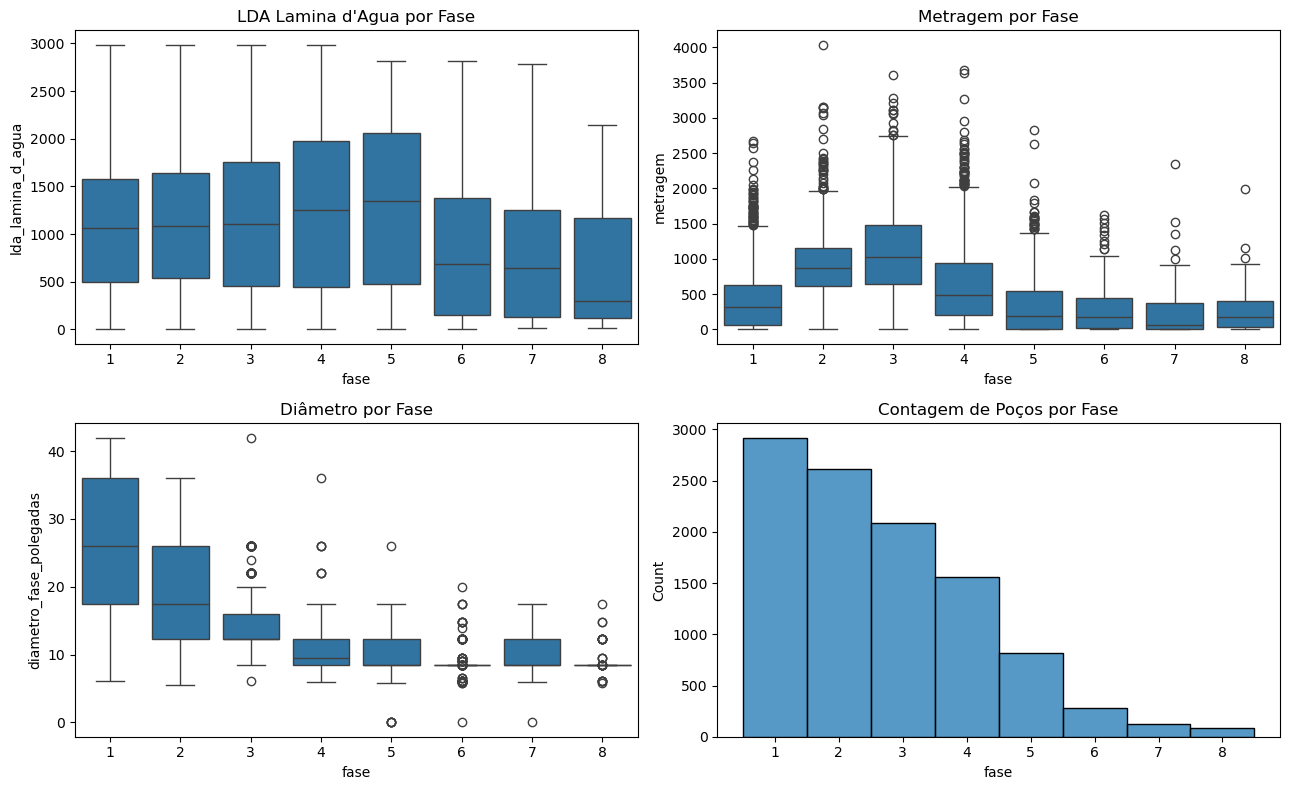

In [55]:
bivariada_fases(df)

### Relações entre features numéricas
Não foi observada relação visível entre as features numéricas. Foi necessário agrupoar por 'fase' para visualizar algum tipo de relação.

In [56]:
numeric_columns

Index(['lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas'], dtype='object')

**A metragem é o valor perfurado naquela fase.**

Os gráficos não são informativos porque estão observando um pedaço da 'série temporal' que são as fases de cada poço. Para enxergar a tendência é preciso considerar esse aspecto.

**Logo, será necessário transformar o dataset para estudar as relações entre as features numéricas.**

**nfases é uma categoria! 'fase' é subcategoria!!**

PARA O TIPO HORIZONTAL:
relações entre
- fase x diametro = à medida que a fase aumenta (o projeto avança, o tempo passa) o diâmetro aumenta?
- fase x lda = à medida que a fase aumenta a lda aumenta?
- fase x metragem (valor perfurado naquela fase) = qual o valor médio de metragem por cada fase?
- fase x metragem_cumulativa = à medida que a fase aumenta a metragem_cumulativa aumenta?
- **nfases é uma categoria! fase é subcategoria!!**
- nfases x metragem_total = quanto mais fases, mais profundo é o poço? Qual é a profundidade média do poço com aquele nfases?
- nfases x lda = quanto mais fases, maior a lda?

*(fazer a mesma análise para o tipo 'VERTICAL')*

#### **Relações entre features numéricas de poços do tipo 'HORIZONTAL'**

In [86]:
# Filtrar dados por tipo_poco
df_horizontal = df[df['tipo_poco'] == 'HORIZONTAL']

Primeiro vou plotar gráficos de **boxplot** para facilitar a visualização da tendência sem perder detalhes da distribuição dos dados.

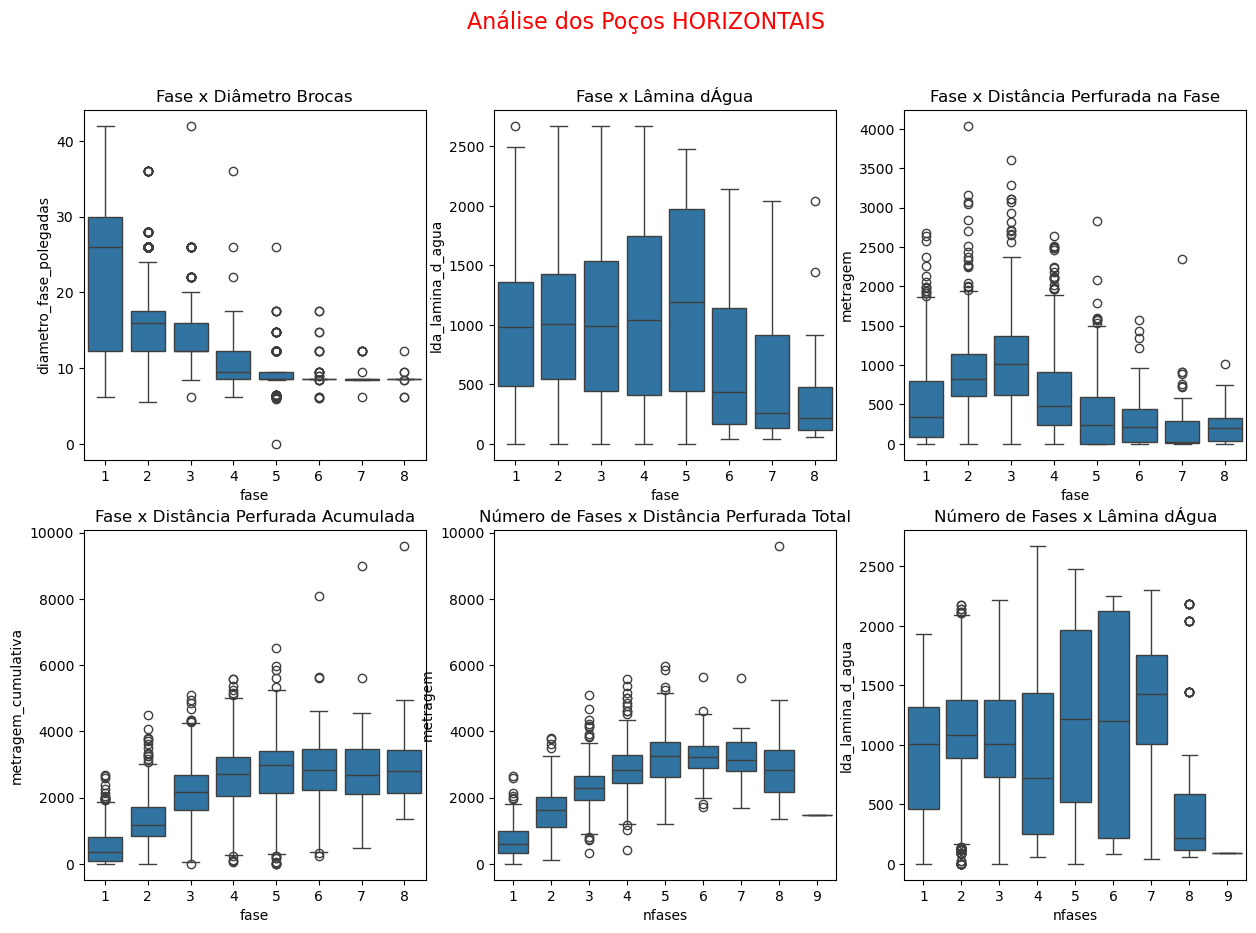

In [107]:
# Plotando a grid dos gráficos para análise

# Definir o tamanho da figura e número de subplots
plt.figure(figsize=(15, 10))

# 1. fase x diametro das brocas
plt.subplot(2, 3, 1)
sns.boxplot(data=df_horizontal, x='fase', y='diametro_fase_polegadas')
plt.title('Fase x Diâmetro Brocas')

# 2. fase x lda
plt.subplot(2, 3, 2)
sns.boxplot(data=df_horizontal, x='fase', y='lda_lamina_d_agua')
plt.title('Fase x Lâmina dÁgua')

# 3. fase x metragem
plt.subplot(2, 3, 3)
sns.boxplot(data=df_horizontal, x='fase', y='metragem')
plt.title('Fase x Distância Perfurada na Fase')

# 4. fase x metragem_cumulativa
df_horizontal = df_horizontal.copy()  # Evita SettingWithCopyWarning
df_horizontal['metragem_cumulativa'] = df_horizontal.groupby('nome_do_poco')['metragem'].cumsum()
plt.subplot(2, 3, 4)
sns.boxplot(data=df_horizontal, x='fase', y='metragem_cumulativa')
plt.title('Fase x Distância Perfurada Acumulada')

# 5. nfases x metragem_total
df_horizontal_total = df_horizontal.groupby('nome_do_poco').agg({'metragem': 'sum', 'nfases': 'max'}).reset_index()
plt.subplot(2, 3, 5)
sns.boxplot(data=df_horizontal_total, x='nfases', y='metragem')
plt.title('Número de Fases x Distância Perfurada Total')

# 6. nfases x lda
plt.subplot(2, 3, 6)
sns.boxplot(data=df_horizontal, x='nfases', y='lda_lamina_d_agua')
plt.title('Número de Fases x Lâmina dÁgua')

# Adicionar título na parte superior centralizada
plt.suptitle('Análise dos Poços HORIZONTAIS', fontsize=16, color='red')

# Salvar a grid de gráficos
save_grid_plot('grid_horizontal_analysis.png')

Agora vou plotar os gráficos de linhas da **média** das features numéricas, para enfatizar a visualização de tendência entre as fases e números de fases.

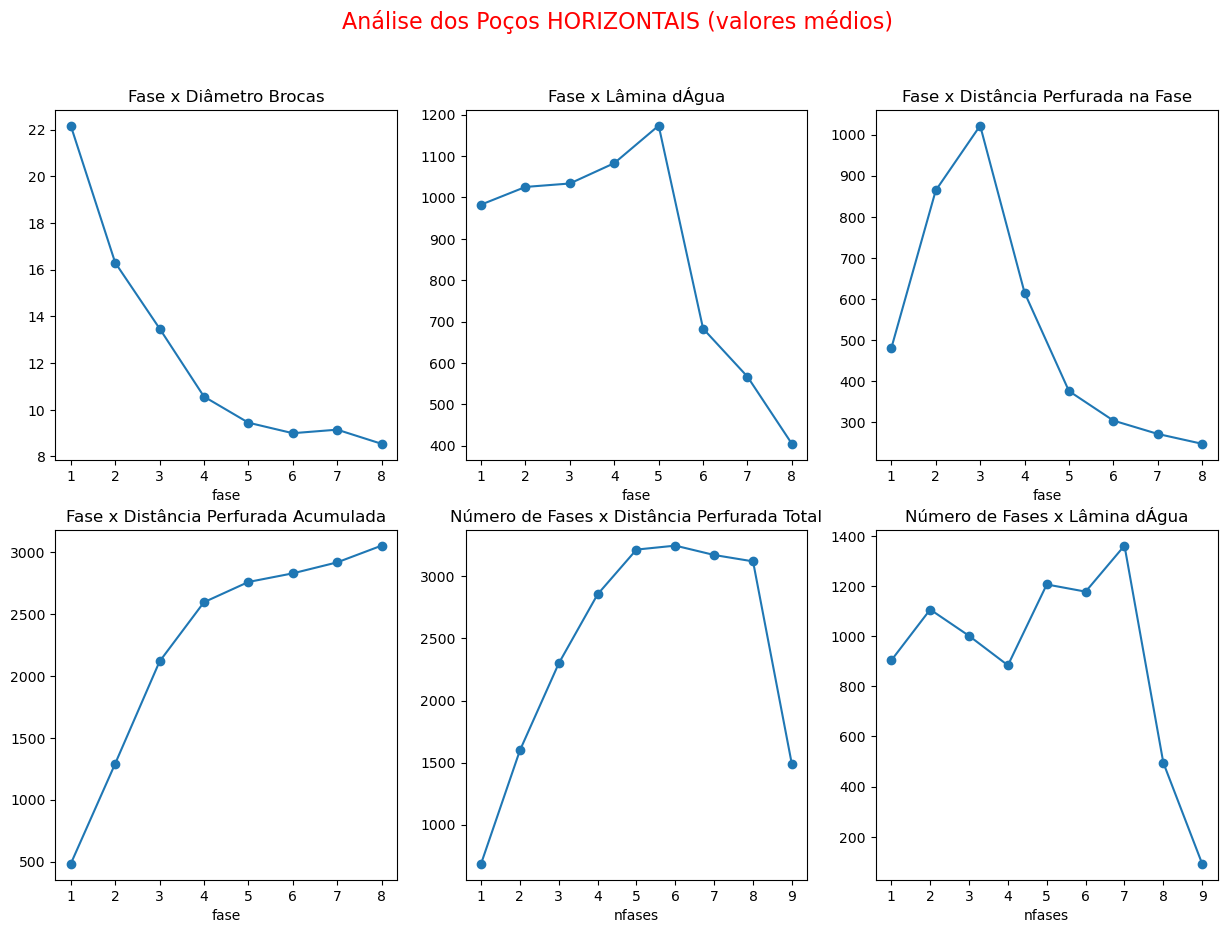

In [109]:
# Plotando a grid dos gráficos para análise

# Definir o tamanho da figura e número de subplots
plt.figure(figsize=(15, 10))

# 1. fase x diametro das brocas
plt.subplot(2, 3, 1)
df_horizontal.groupby('fase', observed=True)['diametro_fase_polegadas'].mean().plot(kind='line', marker='o')
plt.title('Fase x Diâmetro Brocas')

# 2. fase x lda
plt.subplot(2, 3, 2)
df_horizontal.groupby('fase', observed=True)['lda_lamina_d_agua'].mean().plot(kind='line', marker='o')
plt.title('Fase x Lâmina dÁgua')

# 3. fase x metragem
plt.subplot(2, 3, 3)
df_horizontal.groupby('fase', observed=True)['metragem'].mean().plot(kind='line', marker='o')
plt.title('Fase x Distância Perfurada na Fase')

# 4. fase x metragem_cumulativa
df_horizontal.loc[:, 'metragem_cumulativa'] = df_horizontal.groupby('nome_do_poco')['metragem'].cumsum()
plt.subplot(2, 3, 4)
df_horizontal.groupby('fase', observed=True)['metragem_cumulativa'].mean().plot(kind='line', marker='o')
plt.title('Fase x Distância Perfurada Acumulada')

# 5. nfases x metragem_total
df_horizontal_total = df_horizontal.groupby('nome_do_poco').agg({'metragem': 'sum', 'nfases': 'max'}).reset_index()
plt.subplot(2, 3, 5)
df_horizontal_total.groupby('nfases', observed=True)['metragem'].mean().plot(kind='line', marker='o')
plt.title('Número de Fases x Distância Perfurada Total')
plt.xticks(range(1, df_horizontal_total['nfases'].max() + 1))

# 6. nfases x lda
plt.subplot(2, 3, 6)
df_horizontal.groupby('nfases', observed=True)['lda_lamina_d_agua'].mean().plot(kind='line', marker='o')
plt.title('Número de Fases x Lâmina dÁgua')
plt.xticks(range(1, df_horizontal['nfases'].max() + 1))

# Adicionar título na parte superior centralizada
plt.suptitle('Análise dos Poços HORIZONTAIS (valores médios)', fontsize=16, color='red')

# Salvar a grid de gráficos
save_grid_plot('grid_horizontal_analysis_avg.png')

#### **Relações entre features numéricas dos poços do tipo 'VERTICAL'**

In [92]:
df_vertical = df[df['tipo_poco'] == 'VERTICAL']

Primeiro vou plotar gráficos de **boxplot** para facilitar a visualização da tendência sem perder detalhes da distribuição dos dados.

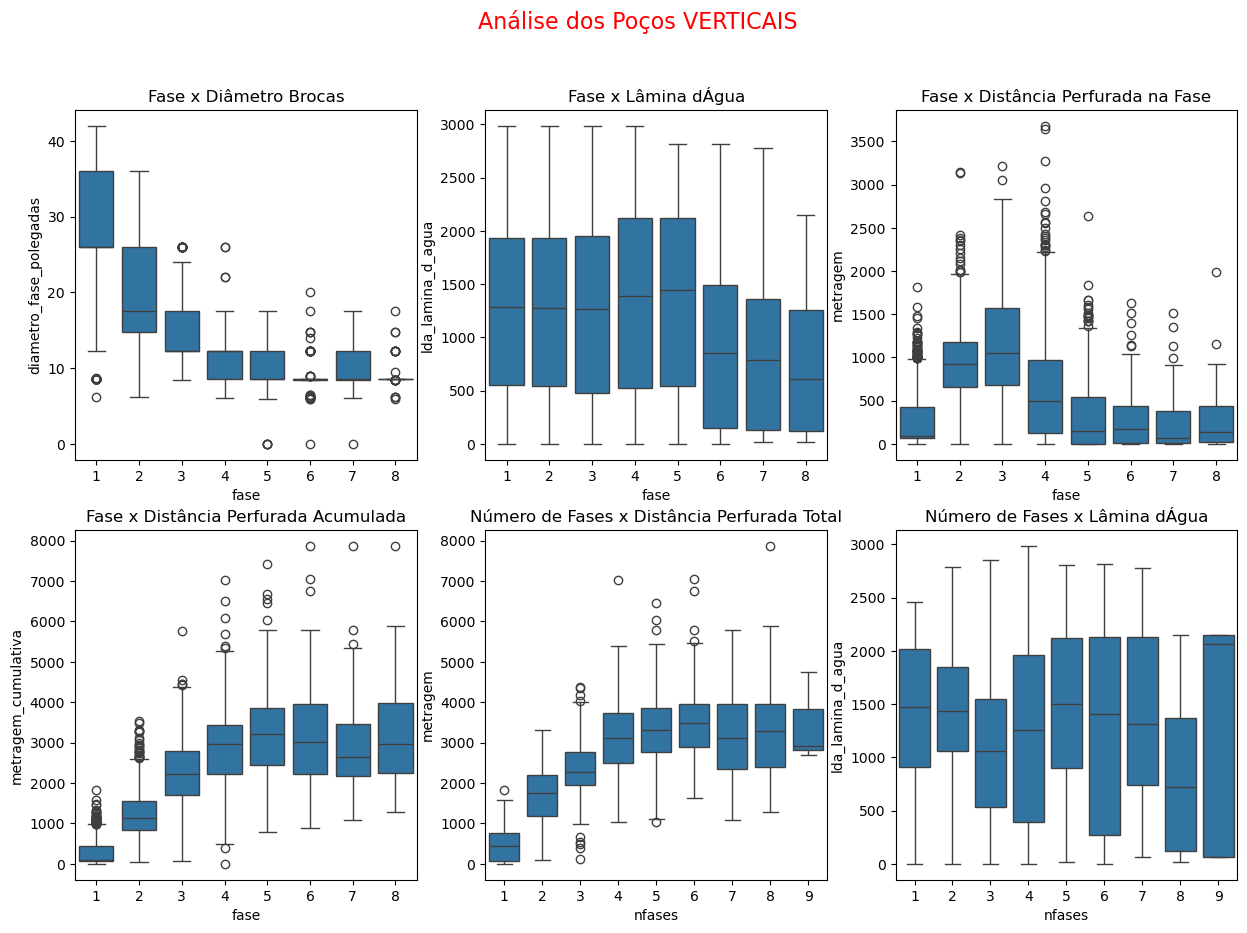

In [110]:
# Plotando a grid dos gráficos para análise

# Definir o tamanho da figura e número de subplots
plt.figure(figsize=(15, 10))

# 1. fase x diametro das brocas
plt.subplot(2, 3, 1)
sns.boxplot(data=df_vertical, x='fase', y='diametro_fase_polegadas')
plt.title('Fase x Diâmetro Brocas')

# 2. fase x lda
plt.subplot(2, 3, 2)
sns.boxplot(data=df_vertical, x='fase', y='lda_lamina_d_agua')
plt.title('Fase x Lâmina dÁgua')

# 3. fase x metragem
plt.subplot(2, 3, 3)
sns.boxplot(data=df_vertical, x='fase', y='metragem')
plt.title('Fase x Distância Perfurada na Fase')

# 4. fase x metragem_cumulativa
df_vertical = df_vertical.copy()  # Evita SettingWithCopyWarning
df_vertical['metragem_cumulativa'] = df_vertical.groupby('nome_do_poco')['metragem'].cumsum()
plt.subplot(2, 3, 4)
sns.boxplot(data=df_vertical, x='fase', y='metragem_cumulativa')
plt.title('Fase x Distância Perfurada Acumulada')

# 5. nfases x metragem_total
df_vertical_total = df_vertical.groupby('nome_do_poco').agg({'metragem': 'sum', 'nfases': 'max'}).reset_index()
plt.subplot(2, 3, 5)
sns.boxplot(data=df_vertical_total, x='nfases', y='metragem')
plt.title('Número de Fases x Distância Perfurada Total')

# 6. nfases x lda
plt.subplot(2, 3, 6)
sns.boxplot(data=df_vertical, x='nfases', y='lda_lamina_d_agua')
plt.title('Número de Fases x Lâmina dÁgua')

# Adicionar título na parte superior centralizada
plt.suptitle('Análise dos Poços VERTICAIS', fontsize=16, color='red')

# Salvar a grid de gráficos
save_grid_plot('grid_vertical_analysis.png')

Agora vou plotar os gráficos de linhas da **média** das features numéricas, para enfatizar a visualização de tendência entre as fases e números de fases.

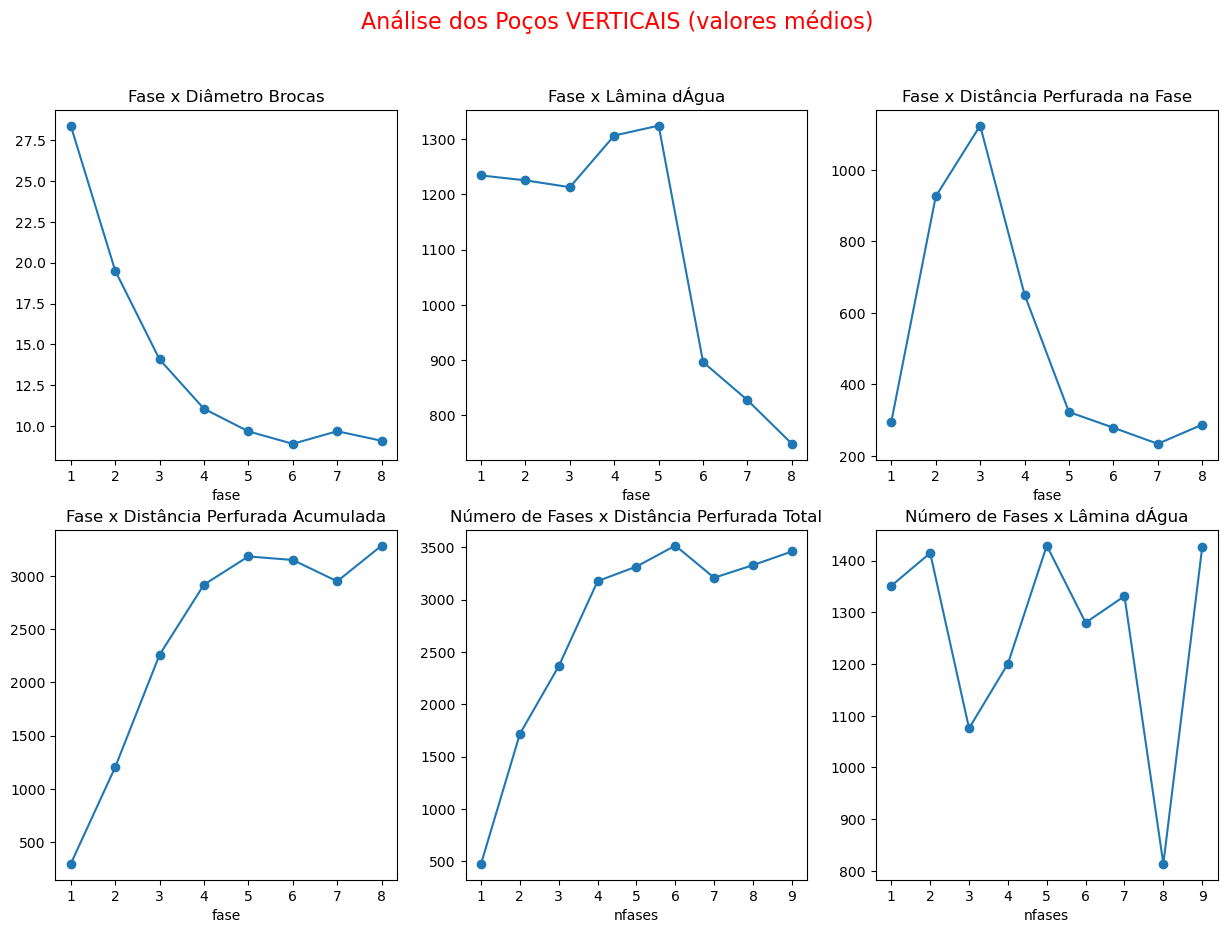

In [111]:
# Plotando a grid dos gráficos para análise

# Definir o tamanho da figura e número de subplots
plt.figure(figsize=(15, 10))

# 1. fase x diametro das brocas
plt.subplot(2, 3, 1)
df_vertical.groupby('fase', observed=True)['diametro_fase_polegadas'].mean().plot(kind='line', marker='o')
plt.title('Fase x Diâmetro Brocas')

# 2. fase x lda
plt.subplot(2, 3, 2)
df_vertical.groupby('fase', observed=True)['lda_lamina_d_agua'].mean().plot(kind='line', marker='o')
plt.title('Fase x Lâmina dÁgua')

# 3. fase x metragem
plt.subplot(2, 3, 3)
df_vertical.groupby('fase', observed=True)['metragem'].mean().plot(kind='line', marker='o')
plt.title('Fase x Distância Perfurada na Fase')

# 4. fase x metragem_cumulativa
df_vertical.loc[:, 'metragem_cumulativa'] = df_vertical.groupby('nome_do_poco')['metragem'].cumsum()
plt.subplot(2, 3, 4)
df_vertical.groupby('fase', observed=True)['metragem_cumulativa'].mean().plot(kind='line', marker='o')
plt.title('Fase x Distância Perfurada Acumulada')

# 5. nfases x metragem_total
df_vertical_total = df_vertical.groupby('nome_do_poco').agg({'metragem': 'sum', 'nfases': 'max'}).reset_index()
plt.subplot(2, 3, 5)
df_vertical_total.groupby('nfases', observed=True)['metragem'].mean().plot(kind='line', marker='o')
plt.title('Número de Fases x Distância Perfurada Total')
plt.xticks(range(1, df_vertical_total['nfases'].max() + 1))

# 6. nfases x lda
plt.subplot(2, 3, 6)
df_vertical.groupby('nfases', observed=True)['lda_lamina_d_agua'].mean().plot(kind='line', marker='o')
plt.title('Número de Fases x Lâmina dÁgua')
plt.xticks(range(1, df_vertical['nfases'].max() + 1))

# Adicionar título na parte superior centralizada
plt.suptitle('Análise dos Poços VERTICAIS (valores médios)', fontsize=16, color='red')

# Salvar a grid de gráficos
save_grid_plot('grid_vertical_analysis_avg.png')

## **Questões de Análise:**

**Poços do tipo HORIZONTAL:**
1. Existe relação entre a **fase** do poço e o **diâmetro da broca** utilizada?
    - Sim. Quanto mais adiantada a fase do poço, menor o diâmetro da broca utilizada.
2. Existe uma relação entre **número de fases** do poço e a profundidade da **lâmina dágua**?
    - Sim. Poços até 7 fases têm lâmina dágua **média** entre 900-1400 metros. Poços com mais fases (8,9) ficam com lâmina (média) abaixo de 500m.
3. Existe uma relação entre **fase** do poço e a **distância perfurada** naquela fase?
    - Sim. Em **média**, a maior distância perfurada ocorre na fase 03; a segunda maior distância perfurada acontece na fase 02.
4. Existe relação entre **fase** do poço e a **distância perfurada acumulada**?
    - Sim. Na média, quanto maior a fase do poço (mais adiantado está o poço), maior a sua distância perfurada.
5. Existe relação entre **número de fases** do poço e a **distância perfurada total**?
    - Não muito. A distância perfurada total atinge seu máximo em poços com 5 fases (mais de 3 mil metros, em média), se mantém em poços com 6-8 fases e é muito menor em poços com 9 fases (~ 1500m).
6. Existe relação entre **número de fases** do poço e a **lâmina dágua**?
    - Não muito. Na **média**, poços com 7 fases são os que começam mais fundo (maior lâmina, aprox. 1400m), mas os poços com 8 ou 9 fases são os mais rasos (menor lâmina, menos de 500m). Poços com 1-6 fases têm lâminas entre 900-1200m.

**Poços do tipo VERTICAL:**
1. Existe relação entre a **fase** do poço e o **diâmetro da broca** utilizada?
    - Sim. Quanto mais adiantada a fase do poço, menor o diâmetro da broca utilizada.
2. Existe uma relação entre **número de fases** do poço e a profundidade da **lâmina dágua**?
    - Sim. Poços na fase 5 têm lâmina dágua **média** de 1300 metros. Poços em fase 6-8 ficam com lâmina (média) abaixo de 900m.
3. Existe uma relação entre **fase** do poço e a **distância perfurada** naquela fase?
    - Sim. Em **média**, a maior distância perfurada ocorre na fase 03; a segunda maior distância perfurada acontece na fase 02.
4. Existe relação entre **fase** do poço e a **distância perfurada acumulada**?
    - Sim. Na média, quanto maior a fase do poço (mais adiantado está o poço), maior a sua distância perfurada.
5. Existe relação entre **número de fases** do poço e a **distância perfurada total**?
    - Sim. Quanto mais fases, maior a distância perfurada, atingindo um máximo de 3500m perfurados (na média) para poços com 6 fases.
6. Existe relação entre **número de fases** do poço e a **lâmina dágua**?
    - Não. Tanto a média quanto a mediana da LDA variam bastante conforme o número de fases do poço. Comparados aos poços HORIZONTAIS, os poços verticais apresentam valores de LDA mais variáveis, com desvio-padrão 21% maior (792 vs 652).

In [122]:
# Calcular o desvio padrão da lâmina d'água para cada tipo de poço com observed=False
std_values = df.groupby('tipo_poco', observed=False)['lda_lamina_d_agua'].std().reset_index()
std_values.columns = ['Tipo de Poço', 'Desvio Padrão da LDA']

# Criar tabela com os valores
std_table = pd.DataFrame(std_values)

std_table.round(2)

,Tipo de Poço,Desvio Padrão da LDA
0,HORIZONTAL,652.93
1,VERTICAL,792.11


# **Modelagem** (Machine Learning)
- Escolha dos modelos
- Treinamento dos modelos
- Avaliação de desempenho dos modelos
- Ajuste de hiperparâmetros

## **Carregando dados**

Carregando os dados do dataset limpo:

In [4]:
# Lendo dataset limpo
df = pd.read_csv('data/df_cleaned.csv')

# Calcular a metragem total para cada poço
df['metragem_total'] = df.groupby('nome_do_poco')['metragem'].transform('sum')

df.head()

,nome_do_poco,fase,tipo_poco,lda_lamina_d_agua,metragem,nfases,diametro_fase_polegadas,metragem_total
0,6C5G4M,1,VERTICAL,598.0,607.0,4,26.00,4559.0
1,6C5G4M,2,VERTICAL,598.0,1306.0,4,17.50,4559.0
2,6C5G4M,3,VERTICAL,598.0,1201.0,4,12.25,4559.0
3,6C5G4M,4,VERTICAL,598.0,1445.0,4,8.50,4559.0
4,8030JC,1,VERTICAL,0.0,410.0,3,17.50,3578.0


Inserindo os dados do poço informado pelo usuário:

In [5]:
# POÇO INFORMADO

# Dados do poço informado
data = {
    'nome_do_poco': ['2JAUCG'] * 4,
    'fase': [1, 2, 3, 4],
    'tipo_poco': ['VERTICAL'] * 4,
    'lda_lamina_d_agua': [598] * 4,
    'metragem': [607, 1306, 1201, 1445],
    'nfases': [4] * 4,
    'diametro_fase_polegadas': [26, 17.5, 12.25, 8.5]
}

# Criar o DataFrame
df_poco_informado = pd.DataFrame(data)

# Adicionar coluna metragem_total ao poço informado
df_poco_informado['metragem_total'] = df_poco_informado['metragem'].sum()
df_poco_informado

,nome_do_poco,fase,tipo_poco,lda_lamina_d_agua,metragem,nfases,diametro_fase_polegadas,metragem_total
0,2JAUCG,1,VERTICAL,598,607,4,26.00,4559
1,2JAUCG,2,VERTICAL,598,1306,4,17.50,4559
2,2JAUCG,3,VERTICAL,598,1201,4,12.25,4559
3,2JAUCG,4,VERTICAL,598,1445,4,8.50,4559


Calculando o score de similaridade = identificar 'manualmente' os poços mais parecidos com o informado.

In [39]:
# Calcula o score de similaridade
df_ordenado = calcular_score_similaridade(df_poco_informado, df)
df_ordenado[['nome_do_poco', 'ranking_similaridade', 'score_similaridade']].head(5).round(4)

,nome_do_poco,ranking_similaridade,score_similaridade
992,6C5G4M,1,1.0000
1062,7021KS,2,0.9682
802,553PEG,3,0.9461
706,4BVJOY,4,0.9450
2808,UD3O5G,5,0.9430


## **Modelo KNN**

### **1. Preparando os dados**
- Preferi encodar 'tipo_poco' como binário para manter a simplicidade do dataset, sem criar novas colunas, dado que só existem 2 tipos.

In [44]:
# Copia 'df' para preservá-lo durante as transformações
df1 = df.copy()

# Selecionar colunas relevantes para KNN
features = ['tipo_poco', 'lda_lamina_d_agua', 'metragem_total', 'nfases', 'fase', 'diametro_fase_polegadas', 'metragem']

# Converter 'tipo_poco' de categórica para numérica (binária)
df1['tipo_poco'] = df1['tipo_poco'].map({'HORIZONTAL': 0, 'VERTICAL': 1})

# Separar características e rótulos
X = df1[features]
y = df1['nome_do_poco']

print("Dataset preparado:")
X.head()

Dataset preparado:


,tipo_poco,lda_lamina_d_agua,metragem_total,nfases,fase,diametro_fase_polegadas,metragem
0,1,598.0,4559.0,4,1,26.00,607.0
1,1,598.0,4559.0,4,2,17.50,1306.0
2,1,598.0,4559.0,4,3,12.25,1201.0
3,1,598.0,4559.0,4,4,8.50,1445.0
4,1,0.0,3578.0,3,1,17.50,410.0


### **2. Treinando o modelo:**

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir o modelo KNN
knn = KNeighborsClassifier(n_neighbors=4)  # K foi atribuído igual ao número de poços semelhantes que desejamos

# Treinar o modelo
knn.fit(X_scaled, y)

print("Modelo KNN treinado.")

Modelo KNN treinado.


### **3. Prever similaridade e ordenar dataset**

In [67]:
# Copia df_poco_informado para preservá-lo durante as transformações
df_poco_informado_encoded = df_poco_informado.copy()

# Converter 'tipo_poco' de categórica para numérica (binário)
df_poco_informado_encoded['tipo_poco'] = df_poco_informado['tipo_poco'].map({'HORIZONTAL': 0, 'VERTICAL': 1})
X_poco_informado_scaled = scaler.transform(df_poco_informado_encoded[features])

# Prever similaridade
distances, indices = knn.kneighbors(X_poco_informado_scaled)

# Obter os poços mais semelhantes
result = df.iloc[indices[0]].copy()
result['similaridade_knn'] = 1 / (1 + distances[0])  # Converter distância KNN para similaridade

# Fazer o MERGE de 'result' com 'df_ordenado' para obter o 'ranking_similaridade'
result_sorted = result.merge(df_ordenado[['nome_do_poco', 'ranking_similaridade', 'score_similaridade']],
                             on='nome_do_poco', how='left')

# Ordenar o DataFrame em ordem decrescente pela 'similaridade_knn'
result_sorted = result_sorted.sort_values(by='similaridade_knn', ascending=False).reset_index(drop=True)

print("Poços mais semelhantes ao poço informado, segundo o KNN:")
result_sorted[['nome_do_poco', 'similaridade_knn', 'ranking_similaridade', 'score_similaridade']].round(4)

Poços mais semelhantes ao poço informado, segundo o KNN:


,nome_do_poco,similaridade_knn,ranking_similaridade,score_similaridade
0,6C5G4M,1.0000,1,1.0000
1,091G7D,0.6694,9,0.9311
2,E6Q0PD,0.6563,11,0.9042
3,0WFQ56,0.6346,7,0.9394


In [48]:
print('Poços mais semelhantes ao informado, segundo o baseline:')
df_ordenado.head(5).round(4)

Poços mais semelhantes ao informado, segundo o baseline:


,nome_do_poco,score_similaridade,ranking_similaridade
992,6C5G4M,1.0000,1
1062,7021KS,0.9682,2
802,553PEG,0.9461,3
706,4BVJOY,0.9450,4
2808,UD3O5G,0.9430,5


#### **Desenvolvendo uma métrica de avaliação dos modelos**
1. O modelo deve gerar um ranking de ocorrências similares ao informado
2. O melhor modelo é aquele que apresenta a maioria das ocorrências realmente mais similares ao informado, no topo do ranking.
3. Para medir '2', usaremos a métrica *Precision at K' (Prec@K), que mede a proporção de itens mais relevantes entre os k itens mais bem classificados pelo algoritmo.

In [68]:
# Precision at K

# O que interessa é analisar os 4 melhores rankeados (top 4)
k = 4

# calcula a proporção de itens relevantes entre os top-4 do modelo
precisao = precision_at_k(result_sorted, k)
print(f"Precisão em {k} do KNN: {precisao * 100:.2f}%")

Precisão em 4 do KNN: 25.00%


## **Semelhança Cosseno**
- Mede a similaridade com base no ângulo dos vetores.

### **1. Preparando os dados**

In [89]:
# Definir as características
features = ['tipo_poco', 'lda_lamina_d_agua', 'metragem_total', 'nfases', 'fase', 'diametro_fase_polegadas', 'metragem']

# Preparar os dados
df1 = df.copy()
df1['tipo_poco'] = df1['tipo_poco'].map({'HORIZONTAL': 0, 'VERTICAL': 1})

### **2. Aplicando o modelo**

In [90]:
# Calcular a similaridade do cosseno
df_ordenado_cosseno = calcular_similaridade_cosseno(df1, df_poco_informado, features, df_ordenado)

### **3. Exibindo resultados**

In [91]:
# Mostrar o DataFrame ordenado
print("Poços mais semelhantes ao poço informado, segundo Similaridade do Cosseno:")
df_ordenado_cosseno[['nome_do_poco', 'similaridade_cosseno', 'ranking_similaridade', 'score_similaridade']].head(4).round(4)

Poços mais semelhantes ao poço informado, segundo Similaridade do Cosseno:


,nome_do_poco,similaridade_cosseno,ranking_similaridade,score_similaridade
0,6C5G4M,1.0000,1,1.0000
1,091G7D,0.9919,9,0.9311
2,4BVJOY,0.9878,4,0.9450
3,0WFQ56,0.9874,7,0.9394


### **4. Avaliando resultados:**

In [92]:
print('Poços mais semelhantes ao informado, segundo o baseline:')
df_ordenado.head(4).round(4)

Poços mais semelhantes ao informado, segundo o baseline:


,nome_do_poco,score_similaridade,ranking_similaridade
992,6C5G4M,1.0000,1
1062,7021KS,0.9682,2
802,553PEG,0.9461,3
706,4BVJOY,0.9450,4


**Precision at K:**

In [94]:
# Precision at K

# O que interessa é analisar os 4 melhores rankeados (top 4)
k = 4

# calcula a proporção de itens relevantes entre os top-4 do modelo
precisao = precision_at_k(df_ordenado_cosseno, k)
print(f"Precisão em {k} do Similaridade Cosseno: {precisao * 100:.2f}%")

Precisão em 4 do Similaridade Cosseno: 50.00%


# **Deploy do Modelo**
- Gravação do modelo treinado

Nesta etapa vamos gravar apenas o 'scaler', já que o melhor modelo, o 'Similaridade Cosseno', não é um objeto feito para ser gravado. Salvando o scaler, garantimos que **conseguiremos recalcular a similaridade cosseno**.

In [98]:
# Preparar o scaler nos mesmos dados utilizados para treinar o modelo cosseno
scaler = StandardScaler()
X = scaler.fit_transform(df1[features])

# Salvar o scaler e as características transformadas
dump(scaler, 'models/scaler_similaridade_cosseno.joblib')

['models/scaler_similaridade_cosseno.joblib']

# **Conclusões**
- Resultados
- Próximos passos

## **Resultados**

In [101]:
print('O poço informado é:')
df_poco_informado

O poço informado é:


,nome_do_poco,fase,tipo_poco,lda_lamina_d_agua,metragem,nfases,diametro_fase_polegadas,metragem_total
0,2JAUCG,1,VERTICAL,598,607,4,26.00,4559
1,2JAUCG,2,VERTICAL,598,1306,4,17.50,4559
2,2JAUCG,3,VERTICAL,598,1201,4,12.25,4559
3,2JAUCG,4,VERTICAL,598,1445,4,8.50,4559


In [99]:
print('Os 04 poços mais semelhantes ao poço informado são:')
df_ordenado.head(4).round(2)

Os 04 poços mais semelhantes ao poço informado são:


,nome_do_poco,score_similaridade,ranking_similaridade
992,6C5G4M,1.00,1
1062,7021KS,0.97,2
802,553PEG,0.95,3
706,4BVJOY,0.94,4


In [103]:
print('Os 04 poços mais semelhantes segundo o KNN: ')
result_sorted[['nome_do_poco', 'similaridade_knn', 'ranking_similaridade', 'score_similaridade']].round(4)

Os 04 poços mais semelhantes segundo o KNN: 


,nome_do_poco,similaridade_knn,ranking_similaridade,score_similaridade
0,6C5G4M,1.0000,1,1.0000
1,091G7D,0.6694,9,0.9311
2,E6Q0PD,0.6563,11,0.9042
3,0WFQ56,0.6346,7,0.9394


In [104]:
print("Poços mais semelhantes ao poço informado, segundo Similaridade do Cosseno:")
df_ordenado_cosseno[['nome_do_poco', 'similaridade_cosseno', 'ranking_similaridade', 'score_similaridade']].head(4).round(4)

Poços mais semelhantes ao poço informado, segundo Similaridade do Cosseno:


,nome_do_poco,similaridade_cosseno,ranking_similaridade,score_similaridade
0,6C5G4M,1.0000,1,1.0000
1,091G7D,0.9919,9,0.9311
2,4BVJOY,0.9878,4,0.9450
3,0WFQ56,0.9874,7,0.9394


## **Próximos passos:**

1. **Explorar Modelos Adicionais**: pretendo testar outros modelos de Machine Learning como Random Forests, Gradient Boosting Machines (GBM), e Support Vector Machines (SVM) para melhorar a Precision-at-K.

2. **Criar um pipeline de Machine Learning**: criar um pipeline para automatizar o processo de ingestão de dados-preparação-treinamento-avaliação, utilizando MLflow para gerenciar os experimentos e ferramentas de cloud para armazenar os dados/modelos.

3. **Publicar o modelo como uma aplicação**: criar uma interface com o usuário onde ele informa os dados do poço desejado e a aplicação retorna os K poços mais semelhantes. Ex: bot do whatsapp, página web (com streamlit).